$\textbf{Python Implementation of Granger Methods}$

**Causal discovery algorithms** are used to discover hypothetical causal relations between variables.

Not discussed in this notebook: 
- neuroscience domain, functional magnetic resonance imaging (fMRI)
- frequency domain, Fourier transform (https://github.com/ViniciusLima94/pyGC)
- many popular ones in matlab, (also R a few) and some only specific for their paper

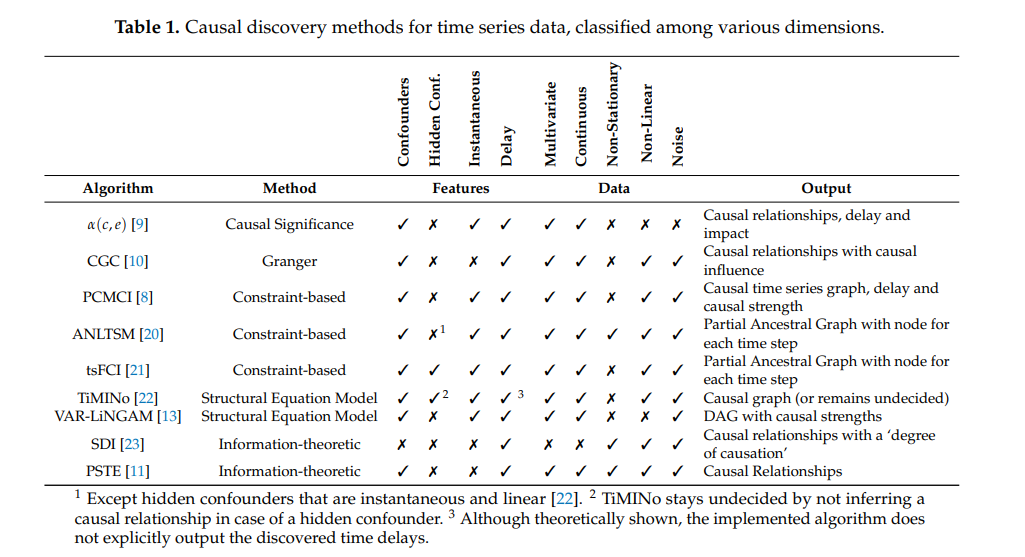

In [5]:
# screenshot/table from https://www.mdpi.com/2504-4990/1/1/19
# TCDF: Temporal Causal Discovery Framework
# https://github.com/M-Nauta/TCDF
from IPython.display import Image
Image(filename='screenshots/causaldiscoverymethods.png')

$\textbf{Granger Causality:}$

According to G-causality, a variable Y ‘Granger causes’ a variable X if information in the past of Y helps predict the future of X with better
accuracy than is possible when considering only information in the
past of X itself

The primary precondition for G-causality analysis is that
the variables must be covariance stationary (CS). Covariance stationarity requires
that the first and second statistical moments (mean and variance) of each variable do not vary with time. If this condition
is not satisfied, MVAR models will be invalid and may contain so-called ‘spurious regression’ results, i.e., correlations that
arise from non-stationarities rather than from relations among variables.
(https://www.sciencedirect.com/science/article/pii/S0165027009006189)

augmented Dickey-Fuller test for CS

BIC/AIC for optimal Lags

$\textbf{Bivariate Linear Granger Test:}$

Autoregressive Model (uses past values to predict current/future values):

$X_{t}=c+\sum _{{i=1}}^{p}\alpha _{i}X_{{t-i}}+\varepsilon _{t}$

$c$ ... intercept

$p$ ... number of past values

$\alpha_i$ ... coefficient for ith past value

$\varepsilon_{t}$ ... error term

$X_{t}=c+\sum _{{i=1}}^{p}\alpha _{i}X_{{t-i}}+\sum _{{i=1}}^{p}\beta _{i}Y_{{t-i}}+\mu _{t}$

$\beta_i$ ... coefficient for ith past value of potential cause

$\mu _{t}$ ... error term

Null hypothesis:

$H_0 = \beta_1 = ... = \beta_p = 0$

perform f-test or chi-square test and obtain p-value
(uses both error terms to calculate sum of squared residuals)


based on https://github.com/dgwozdz/HN_SO_analysis
This article examines data from Stackoverflow and Hackernews trying to answer the question whether an intuitive relationship between the two is reflected in available data. It is a combination of Exploratory Data Analysis (EDA) with some descriptive statistics. Maybe the approach they used to answer their question, can be useful too for the food subreddits?

In [2]:
from dataset_utils import simulate_var, simulate_lorenz_96
from plot_utils import plot_all_and_first_points
import models.linvar as mlin
from IPython.display import Image
import torch
import numpy as np
from models.cmlp import cMLP, train_model_ista
from plot_utils import plot_gc_graphs
from statsmodels.tsa.stattools import grangercausalitytests
from test_utils import dickey_fuller
from statsmodels.tsa.api import VAR 
from models.crnn import cRNN, train_model_ista
from models.clstm import cLSTM, train_model_ista as train_model_ista_clstm
from models.cmlp import cMLP, train_model_ista as train_model_ista_cmlp

ADF Statistic: -4.665579
p-value: 0.000098
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Reject H0 - Time Series is Stationary
ADF Statistic: -8.437057
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject H0 - Time Series is Stationary


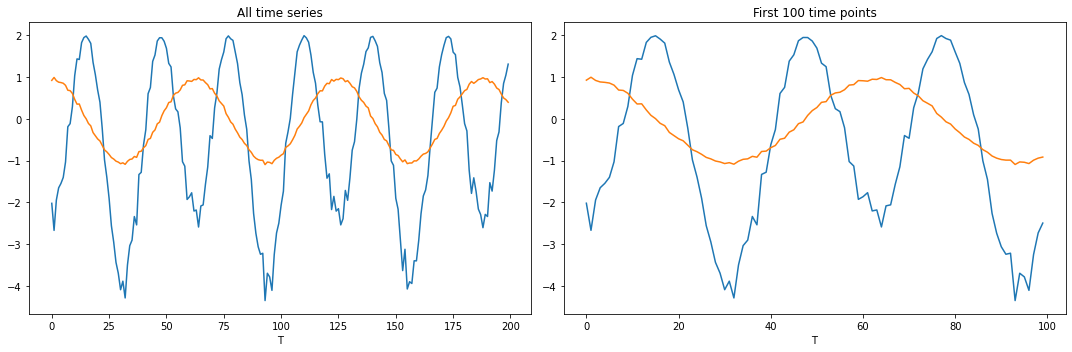


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8347  , p=0.3620  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=0.8475  , p=0.3573  , df=1
likelihood ratio test: chi2=0.8457  , p=0.3578  , df=1
parameter F test:         F=0.8347  , p=0.3620  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8972  , p=0.4094  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=1.8410  , p=0.3983  , df=2
likelihood ratio test: chi2=1.8325  , p=0.4000  , df=2
parameter F test:         F=0.8972  , p=0.4094  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9628  , p=0.4114  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=2.9947  , p=0.3924  , df=3
likelihood ratio test: chi2=2.9722  , p=0.3959  , df=3
parameter F test:         F=0.9628  , p=0.4114  , df_denom=190, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3928  , p=0.2381  

In [6]:
np.random.seed(10)
Y = np.cos(np.linspace(0, 20, 200)) - 0.1 * np.random.random(200)
X = - 5 * Y ** 2 + 0.3 * Y + 2 - 0.05 * np.random.random(200)
data = np.vstack([X, Y]).T

# check if stationary
dickey_fuller(X)
dickey_fuller(Y)


# The data for testing whether the time series in the second column Granger causes
# the time series in the first column. Missing values are not supported.

plot_all_and_first_points(data, 100)
grangercausalitytests(data, maxlag=15) # number of lags 6+ for rejection of H0

data = np.vstack([Y, X]).T

# The Bayesian Information Criterion is a method for scoring and selecting a model.
# find optimal number of lags for model prediction
model = VAR (data)
lag_orders = model.select_order(15)
print("----------------------------")
print("BIC value: {}".format(lag_orders.bic))
print("----------------------------")
granger_tests_dict = grangercausalitytests(data, maxlag=15) # always fail to reject to H0

Optimal number of lags for granger causality:
The trade-off is between bias and power. Too few lags, you have a biased test because of the residual auto-correlation. Too many, you allow for potentially spurious rejections of the null - some random correlation might make it look like X helps predict Y. Whether or not that's a practical concern depends on your data.

Can be used Pairwise for multivariate data.
This is called Exhaustive Granger Method. (not done here, but there are even a few blogs/articals/towardsdatascience where these method is described) e.g (https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2)

$\textbf{Multivariate Linear Granger Test:}$

**multivariate GC:**
Generialization of AR Model for multidimensional data = Vector Autoregressive Model (VAR)


$X_{t}=\nu +\sum _{{k=1}}^{K}\Psi _{k}X_{{t-k}}+\varepsilon _{t}$


$K$ ... order of VAR, number of Lags

$\Psi$ ... $p x p$ coeffienct matrix

$p$ ... number of time series

usually fitted via multivariate least squares

obtain calculated coeffiecents from VAR model and use them in statistical tests (e.g f-test)

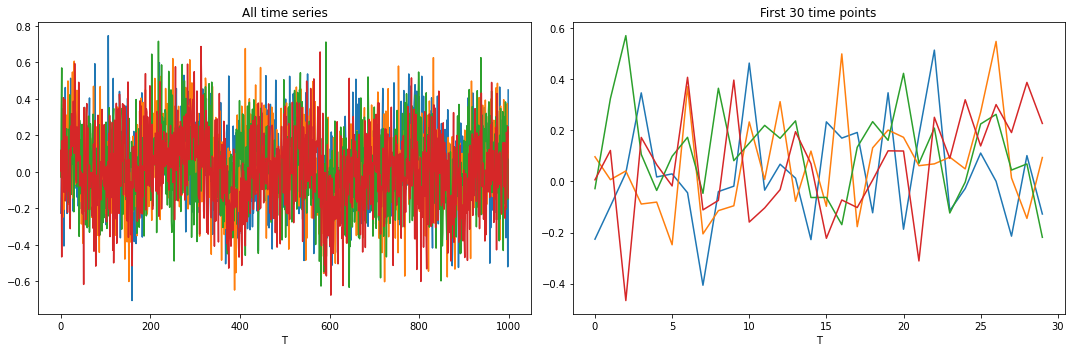

True variable usage = 50.00%
Estimated variable usage = 50.00%
Accuracy = 100.00%
Precision = 100.00%
Recall = 100.00%
F1 Score = 100.00%


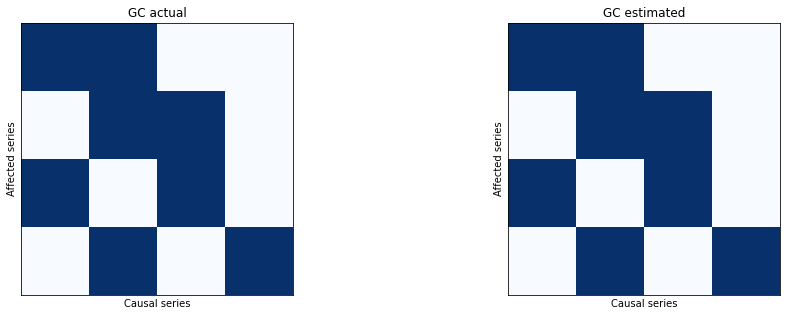

True variable usage = 25.00%
Estimated variable usage = 26.56%
Accuracy = 92.19%
Precision = 82.35%
Recall = 87.50%
F1 Score = 84.85%


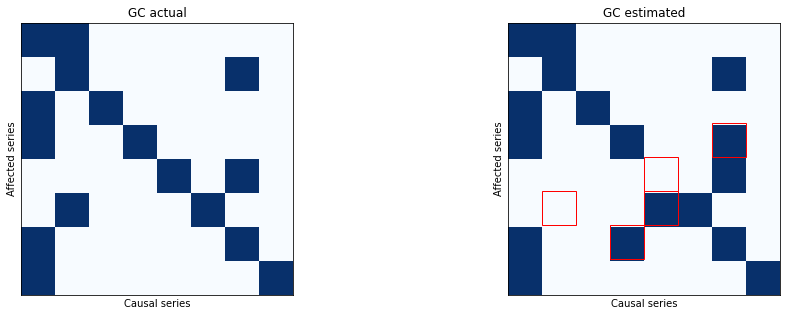

True variable usage = 40.00%
Estimated variable usage = 56.00%
Accuracy = 78.00%
Precision = 66.07%
Recall = 92.50%
F1 Score = 77.08%


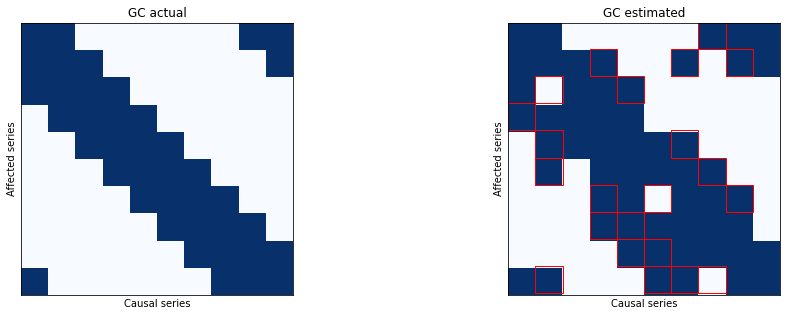

In [17]:
X, _, GC = simulate_var(p=4, T=1000, lag=10, seed=42, sd=0.2)
plot_all_and_first_points(X, 30)
pvals, reject = mlin.LinVAR(X, 5).infer_causal_structure(kind="f")
plot_gc_graphs(GC, reject)

X, _, GC = simulate_var(p=8, T=1000, lag=10, seed=42, sd=0.2)
pvals, reject = mlin.LinVAR(X, 5).infer_causal_structure(kind="f")
plot_gc_graphs(GC, reject)

X, GC = simulate_lorenz_96(p=10, T=1000, F=10)

pvals, reject = mlin.LinVAR(X, 5).infer_causal_structure(kind="f")
plot_gc_graphs(GC, reject)

**Lasso Granger Method**

introduces penalty term:
$\lambda ||\Psi||_1$

additional hyper parameter lambda

Paper:
https://www.andrewoarnold.com/frp781-arnold.pdf (matlab)
translation from matlab to python:
https://github.com/arahatashun/Granger-causality-python
uses glmnet -> not supported for Windows

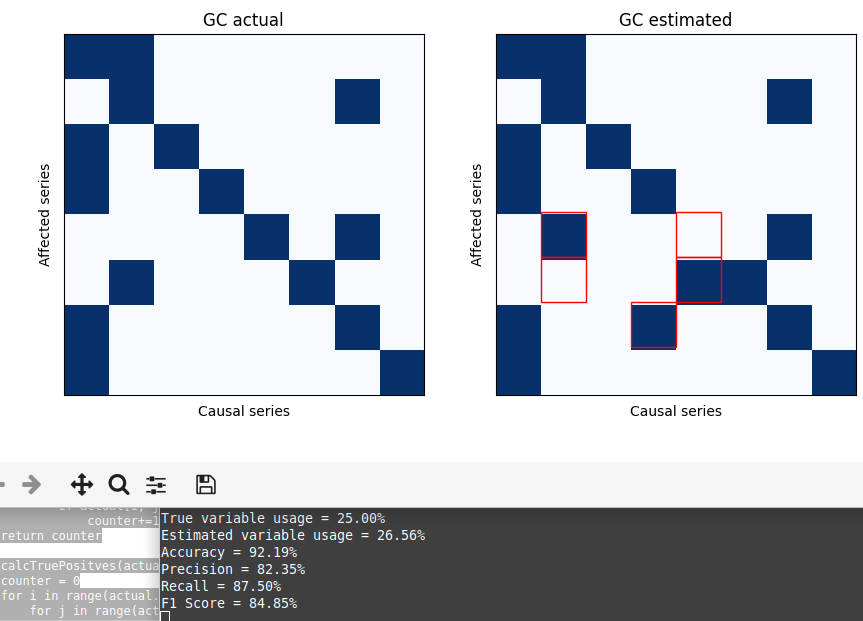

In [14]:
Image(filename='screenshots/lassomethodlinear.png')

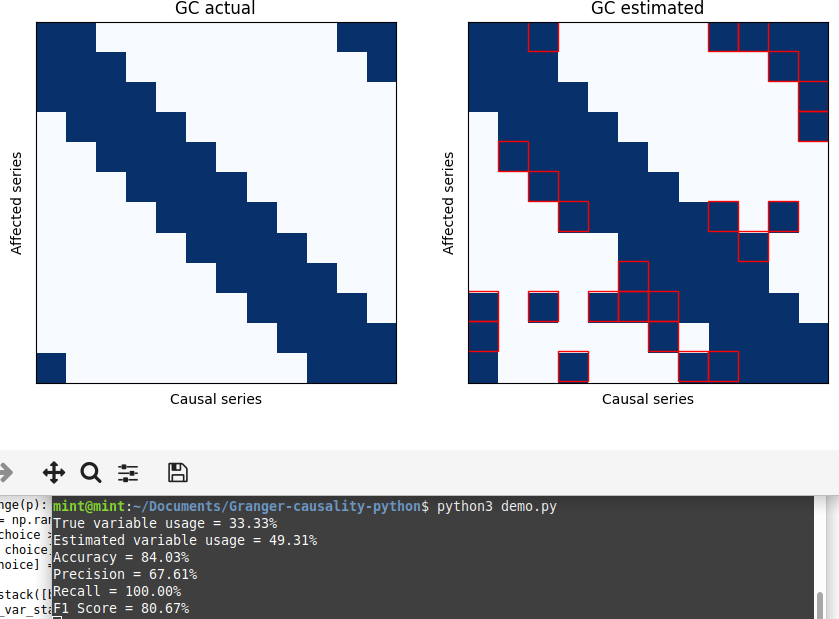

In [13]:
Image(filename='screenshots/lassomethodnonlinear.png')

$\textbf{Multivariate Nonlinear Granger Test:}$

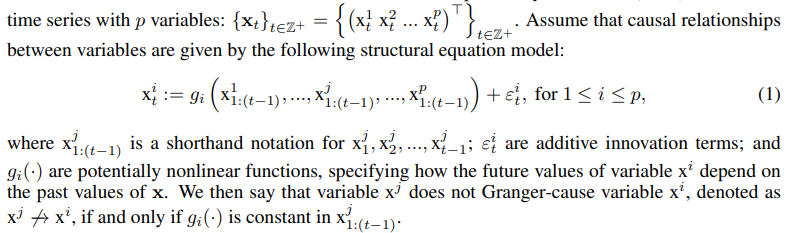

In [3]:
# screenshot/definition from https://openreview.net/forum?id=DEa4JdMWRHp
Image(filename='screenshots/nonlinearmultigcdefinition.png') 

In [57]:
X, GC = simulate_lorenz_96(p=10, T=1000, F=10)

gpu = torch.device('cuda')
X_torch = torch.tensor(X[np.newaxis], dtype=torch.float32, device=gpu)

crnn = cRNN(X.shape[-1], hidden=100).cuda(device=gpu)
'''
context: length for short overlapping subsequences.
      lam: parameter for nonsmooth regularization.
      lam_ridge: parameter for ridge regularization on output layer.
'''
train_loss_list = train_model_ista(
    crnn, X_torch, context=15, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=2000,
    check_every=50)

----------Iter = 50----------
Loss = 23.158661
Variable usage = 100.00%
----------Iter = 100----------
Loss = 13.794774
Variable usage = 24.00%
----------Iter = 150----------
Loss = 12.642390
Variable usage = 23.00%
----------Iter = 200----------
Loss = 11.794837
Variable usage = 26.00%
----------Iter = 250----------
Loss = 11.122006
Variable usage = 28.00%
----------Iter = 300----------
Loss = 10.588999
Variable usage = 29.00%
----------Iter = 350----------
Loss = 10.171353
Variable usage = 30.00%
----------Iter = 400----------
Loss = 9.838598
Variable usage = 30.00%
----------Iter = 450----------
Loss = 9.567771
Variable usage = 29.00%
----------Iter = 500----------
Loss = 9.340368
Variable usage = 29.00%
----------Iter = 550----------
Loss = 9.145179
Variable usage = 29.00%
----------Iter = 600----------
Loss = 8.974141
Variable usage = 30.00%
----------Iter = 650----------
Loss = 8.822634
Variable usage = 31.00%
----------Iter = 700----------
Loss = 8.687128
Variable usage = 31.00%

True variable usage = 40.00%
Estimated variable usage = 36.00%
Accuracy = 94.00%
Precision = 97.22%
Recall = 87.50%
F1 Score = 92.11%


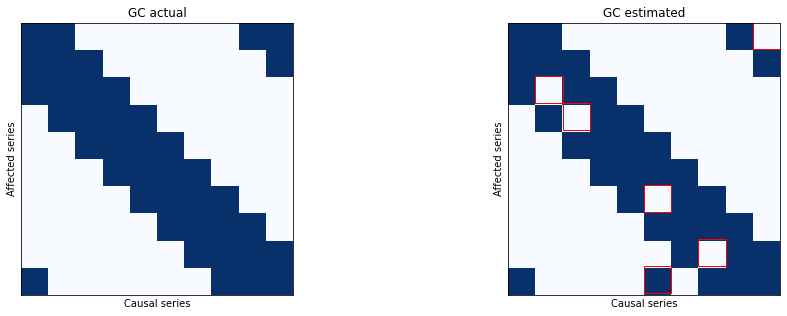

In [58]:
# eval
GC_est = crnn.GC().cpu().data.numpy()
plot_gc_graphs(GC, GC_est)

In [59]:
X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=gpu)
clstm = cLSTM(X.shape[-1], hidden=100).cuda(device=gpu)
train_loss_list_clstm = train_model_ista_clstm(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=2000,
    check_every=50)

----------Iter = 50----------
Loss = 86.468170
Variable usage = 100.00%
----------Iter = 100----------
Loss = 37.742046
Variable usage = 100.00%
----------Iter = 150----------
Loss = 22.071196
Variable usage = 20.00%
----------Iter = 200----------
Loss = 20.605349
Variable usage = 15.00%
----------Iter = 250----------
Loss = 19.733006
Variable usage = 13.00%
----------Iter = 300----------
Loss = 19.144186
Variable usage = 12.00%
----------Iter = 350----------
Loss = 18.715145
Variable usage = 12.00%
----------Iter = 400----------
Loss = 18.377546
Variable usage = 12.00%
----------Iter = 450----------
Loss = 18.092365
Variable usage = 15.00%
----------Iter = 500----------
Loss = 17.835354
Variable usage = 17.00%
----------Iter = 550----------
Loss = 17.592886
Variable usage = 20.00%
----------Iter = 600----------
Loss = 17.360058
Variable usage = 22.00%
----------Iter = 650----------
Loss = 17.134624
Variable usage = 24.00%
----------Iter = 700----------
Loss = 16.915342
Variable usage 

True variable usage = 40.00%
Estimated variable usage = 31.00%
Accuracy = 91.00%
Precision = 100.00%
Recall = 77.50%
F1 Score = 87.32%


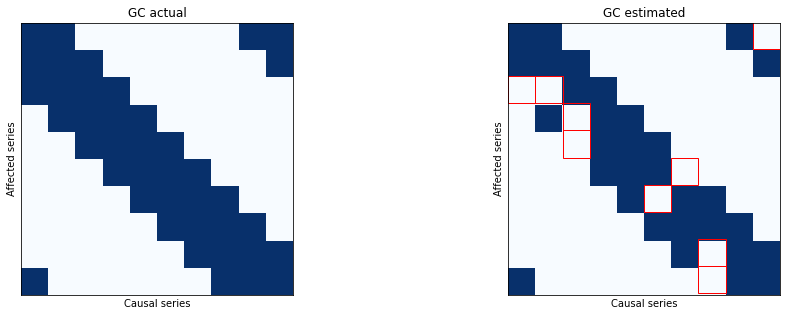

In [60]:
GC_est = clstm.GC().cpu().data.numpy()
plot_gc_graphs(GC, GC_est)

In [66]:
X_lin, beta, GC = simulate_var(p=8, T=1000, lag=10, seed=42, sd=0.2)
X = torch.tensor(X_lin[np.newaxis], dtype=torch.float32, device=gpu)
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100]).cuda(device=gpu)
train_loss_list = train_model_ista_cmlp(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', max_iter=50000,
    check_every=100)

----------Iter = 100----------
Loss = 0.165525
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.160807
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.156921
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.153402
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.150093
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.146921
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.143850
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.140856
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.137926
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.135049
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.132218
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.129431
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.126685
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.123979
Variable usa

----------Iter = 11400----------
Loss = 0.045868
Variable usage = 79.69%
----------Iter = 11500----------
Loss = 0.045821
Variable usage = 78.12%
----------Iter = 11600----------
Loss = 0.045782
Variable usage = 71.88%
----------Iter = 11700----------
Loss = 0.045747
Variable usage = 68.75%
----------Iter = 11800----------
Loss = 0.045717
Variable usage = 67.19%
----------Iter = 11900----------
Loss = 0.045690
Variable usage = 65.62%
----------Iter = 12000----------
Loss = 0.045664
Variable usage = 64.06%
----------Iter = 12100----------
Loss = 0.045641
Variable usage = 62.50%
----------Iter = 12200----------
Loss = 0.045619
Variable usage = 62.50%
----------Iter = 12300----------
Loss = 0.045598
Variable usage = 59.38%
----------Iter = 12400----------
Loss = 0.045580
Variable usage = 57.81%
----------Iter = 12500----------
Loss = 0.045564
Variable usage = 56.25%
----------Iter = 12600----------
Loss = 0.045549
Variable usage = 54.69%
----------Iter = 12700----------
Loss = 0.045535
Va

----------Iter = 22700----------
Loss = 0.045282
Variable usage = 25.00%
----------Iter = 22800----------
Loss = 0.045280
Variable usage = 25.00%
----------Iter = 22900----------
Loss = 0.045278
Variable usage = 25.00%
----------Iter = 23000----------
Loss = 0.045276
Variable usage = 25.00%
----------Iter = 23100----------
Loss = 0.045274
Variable usage = 25.00%
----------Iter = 23200----------
Loss = 0.045271
Variable usage = 25.00%
----------Iter = 23300----------
Loss = 0.045269
Variable usage = 23.44%
----------Iter = 23400----------
Loss = 0.045268
Variable usage = 21.88%
----------Iter = 23500----------
Loss = 0.045267
Variable usage = 21.88%
----------Iter = 23600----------
Loss = 0.045267
Variable usage = 21.88%
----------Iter = 23700----------
Loss = 0.045266
Variable usage = 21.88%
----------Iter = 23800----------
Loss = 0.045266
Variable usage = 21.88%
----------Iter = 23900----------
Loss = 0.045266
Variable usage = 21.88%
----------Iter = 24000----------
Loss = 0.045265
Va

----------Iter = 34000----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34100----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34200----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34300----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34400----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34500----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34600----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34700----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34800----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 34900----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 35000----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 35100----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 35200----------
Loss = 0.045263
Variable usage = 21.88%
----------Iter = 35300----------
Loss = 0.045263
Va

----------Iter = 45300----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45400----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45500----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45600----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45700----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45800----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 45900----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46000----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46100----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46200----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46300----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46400----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46500----------
Loss = 0.045240
Variable usage = 20.31%
----------Iter = 46600----------
Loss = 0.045240
Va

True variable usage = 25.00%
Estimated variable usage = 20.31%
Accuracy = 73.44%
Precision = 46.15%
Recall = 37.50%
F1 Score = 41.38%


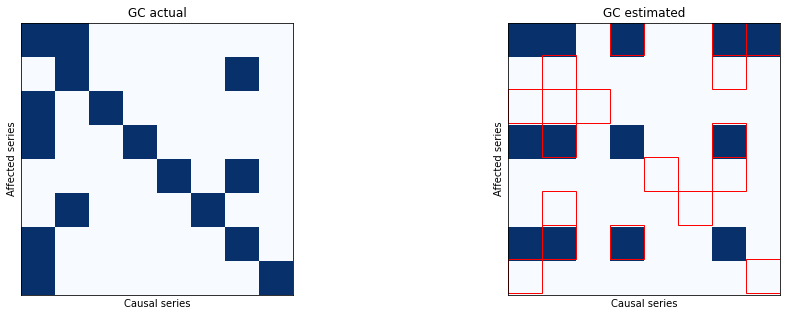

In [67]:
GC_est = cmlp.GC().cpu().data.numpy()
plot_gc_graphs(GC, GC_est)